# Kundur Two Areas

### Import Libraries

In [1]:
import subprocess, sys, os
import urllib.request

dpsim_root_dir = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
sys.path.insert(0, os.path.join(dpsim_root_dir, 'python/src/dpsim/'))
sys.path.insert(0, os.path.join(dpsim_root_dir, 'build'))

import matpower
import dpsimpy
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib widget

### Get simulation data

In [2]:
if not os.path.exists('Kundur2Areas-data'):
    os.mkdir('Kundur2Areas-data')

url_static = 'https://github.com/martinmoraga/dpsim_data/raw/main/Kundur2Areas/matpower/Kundur2Areas.mat'
url_dynamic = 'https://github.com/martinmoraga/dpsim_data/raw/main/Kundur2Areas/matpower/Kundur2Areas_dyn.mat'
local_file_static = './Kundur2Areas-data/Kundur2Areas.mat'
local_file_dynamic = './Kundur2Areas-data/Kundur2Areas_dyn.mat'
urllib.request.urlretrieve(url_static, local_file_static)
urllib.request.urlretrieve(url_dynamic, local_file_dynamic)

('./Kundur2Areas-data/Kundur2Areas_dyn.mat',
 <http.client.HTTPMessage at 0x72fc9c79fa60>)

### Configure simulation/cosimulation

In [3]:
time_step = 50e-6
t_f = 1e-3
start_fault_time = 0.5
fault_clearing_time = 0.6

switch_closed = 1 # fault resistance
node_fault = "N1"

#  cosimulation parameters
H = 0.2e-3
interp = 'linear'
k_map = {'zoh': 0, 'linear': 1}
k = k_map[interp]

cosim_config = {
    "number_topologies": 2,
    "nodes": [["gnd", "N1", "N2", "N5", "N6", "N7", "N8"], ["N3", "N4", "N11", "N10", "N9", "N8"]],
    "eq_component": ["VS", "CS"],
    "split_node": "N8",
    "sim_names": ["EMT_Cosim_Kundur2Areas_dyn_S1", "EMT_Cosim_Kundur2Areas_dyn_S2"]
}

### 1. Powerflow for initialization

In [4]:
sim_name_pf = 'Kundur2Areas_PF'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_pf)

# read and create dpsim topology
mpc_reader_pf = matpower.Reader(mpc_file_path=local_file_static, mpc_name='Kundur2Areas')
mpc_reader_pf.load_mpc(domain=matpower.Domain.PF)
system_pf = mpc_reader_pf.system

# log results
logger = dpsimpy.Logger(sim_name_pf)
for node in system_pf.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
    logger.log_attribute(node.name()+'.S', 's', node)

# Parametrize and run simulation
sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.info)
sim_pf.set_system(system_pf)
sim_pf.set_time_step(1)
sim_pf.set_final_time(0.1)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.do_init_from_nodes_and_terminals(False)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.add_logger(logger)
sim_pf.run()

/workspaces/dpsim/python/src/dpsim/matpower.py:396: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gen.set_parameters(gen_baseS, gen_baseV, gen_p, gen_v, bus_type, gen_q)
[15:17:49.168794 Kundur2Areas_PF info] Initialize simulation: Kundur2Areas_PF
[15:17:49.172917 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N5
[15:17:49.172928 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N6
[15:17:49.172934 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N7
[15:17:49.172937 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N7
[15:17:49.172942 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N8
[15:17:49.172947 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N9
[15:17:49.172950 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N9
[15:17:49.172955 Kundur2Areas_PF_PF_Solver warning] Unable

### 2. Dynamic, Monolithic simulation

#### Declare some functions

In [5]:
def Kundur2Areas_dyn(domain="SP"):
    if domain=="SP":
        matpower_domain = matpower.Domain.SP
        dpsim_domain = dpsimpy.Domain.SP
    elif domain=="DP":
        matpower_domain = matpower.Domain.DP
        dpsim_domain = dpsimpy.Domain.DP
    else:
        domain="EMT"
        matpower_domain = matpower.Domain.EMT
        dpsim_domain = dpsimpy.Domain.EMT

    sim_name_dyn = domain + "_Kundur2Areas_dyn"        
    dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn)

    mpc_reader_dyn = matpower.Reader(mpc_file_path=local_file_static, mpc_name='Kundur2Areas',
                                     mpc_dyn_file_path=local_file_dynamic, mpc_dyn_name='Kundur2Areas_dyn')
    mpc_reader_dyn.create_dpsim_objects(domain=matpower_domain, frequency=60,
                                     with_avr=False, with_tg=False, with_pss=False)

    ### Extend topology with 3ps fault
    sw = mpc_reader_dyn.add_3ph_faut(node_fault, switch_closed=switch_closed, switch_open=1e18)
    
    # create dpsim topology
    mpc_reader_dyn.create_dpsim_topology()

    #initialize node voltages using pf results
    system_dyn = mpc_reader_dyn.system
    system_dyn.init_with_powerflow(system_pf, dpsim_domain)

    # log results
    logger = dpsimpy.Logger(sim_name_dyn)
    for node in system_dyn.nodes:
        logger.log_attribute(node.name()+'.V', 'v', node)

    # Log line currents
    for line_name in ["line3_7-8", "line4_7-8", "line5_8-9", "line6_8-9"]:
        logger.log_attribute('{}.I'.format(line_name), 'i_intf', mpc_reader_dyn.dpsimpy_comp_dict[line_name][0])
        logger.log_attribute('{}.t'.format(line_name), 'ParallelCurrentNode0', mpc_reader_dyn.dpsimpy_comp_dict[line_name][0])
        logger.log_attribute('{}.ParallelCurrentNode1'.format(line_name), 'ParallelCurrentNode1', mpc_reader_dyn.dpsimpy_comp_dict[line_name][0])

    # Parametrize and run simulation
    sim = dpsimpy.Simulation(sim_name_dyn, dpsimpy.LogLevel.info)
    sim.set_system(system_dyn)
    if domain=="SP":
        sim.set_time_step(1e-3)
    else:
        sim.set_time_step(time_step)
    sim.set_final_time(t_f)
    sim.set_domain(dpsim_domain)
    sim.set_solver(dpsimpy.Solver.MNA)
    sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.KLU)
    sim.do_init_from_nodes_and_terminals(True)
    sim.add_logger(logger)
    sim.do_system_matrix_recomputation(True)

    # add events
    sw_event_1 = dpsimpy.event.SwitchEvent(start_fault_time, sw, True)
    sw_event_2 = dpsimpy.event.SwitchEvent(fault_clearing_time, sw, False)
    sim.add_event(sw_event_1)
    sim.add_event(sw_event_2)
    
    sim.run()

    return [sim_name_dyn, sim]

#### Dpsim Simulations

In [6]:
[sim_name_dyn_emt, sim] = Kundur2Areas_dyn(domain="EMT")

[15:17:49.360821 EMT_Kundur2Areas_dyn info] Initialize simulation: EMT_Kundur2Areas_dyn
[15:17:49.360883 MnaSolverFactory info] creating KLUAdapter solver implementation
[15:17:49.387618 EMT_Kundur2Areas_dyn info] Scheduling tasks.
[15:17:49.388095 EMT_Kundur2Areas_dyn info] Scheduling done.
[15:17:49.388098 EMT_Kundur2Areas_dyn info] Opening interfaces.
[15:17:49.388100 EMT_Kundur2Areas_dyn info] Start synchronization with remotes on interfaces
[15:17:49.388101 EMT_Kundur2Areas_dyn info] Synchronized simulation start with remotes
[15:17:49.388103 EMT_Kundur2Areas_dyn info] Start simulation: EMT_Kundur2Areas_dyn
[15:17:49.388106 EMT_Kundur2Areas_dyn info] Time step: 5.000000e-05
[15:17:49.388107 EMT_Kundur2Areas_dyn info] Final time: 1.000000e-03
[15:17:49.390860 EMT_Kundur2Areas_dyn info] Simulation calculation time: 0.002683
[15:17:49.390976 EMT_Kundur2Areas_dyn info] Simulation finished.


### Split topologie at node 8

#### Create topologies for cosimulation

In [7]:
sim_name_fault = "Cosim_Kundur2Areas_Fault"        
dpsimpy.Logger.set_log_dir('logs/' + sim_name_fault)

# load dynamic topology
mpc_reader_dyn = matpower.Reader(mpc_file_path=local_file_static, mpc_name='Kundur2Areas',
                                 mpc_dyn_file_path=local_file_dynamic, mpc_dyn_name='Kundur2Areas_dyn')
mpc_reader_dyn.create_dpsim_objects(domain=matpower.Domain.EMT, frequency=60, 
                                 with_avr=False, with_tg=False, with_pss=False)

### Extend topology with 3ps fault
sw = mpc_reader_dyn.add_3ph_faut(node_fault, switch_closed=switch_closed, switch_open=1e18)

# create dpsim topology
mpc_reader_dyn.create_dpsim_topology()

#initialize node voltages using pf results
system_dyn = mpc_reader_dyn.system
system_dyn.init_with_powerflow(system_pf, dpsimpy.Domain.EMT)

#create topologies for cosimulation
[sys_topo_1, sys_topo_2] = mpc_reader_dyn.create_cosim_topologies(cosim_config)

In [8]:
#sys_topo_2

#### Prepare 2nd sub topology

In [9]:
sim_name_dyn_s2 = cosim_config["sim_names"][1] + '_' + interp + '_' + str(H)
dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn_s2)

# set initial reference current of current source
init_current = sim_pf.get_idobj_attr("line5_8-9", 'current_vector').get()[1][0] + sim_pf.get_idobj_attr("line6_8-9", 'current_vector').get()[1][0] - \
               sim.get_idobj_attr("line5_8-9", 'ParallelCurrentNode1').get()[0][0] - sim.get_idobj_attr("line6_8-9", 'ParallelCurrentNode1').get()[0][0]
print(sim_pf.get_idobj_attr("line5_8-9", 'current_vector').get()[1][0] + sim_pf.get_idobj_attr("line6_8-9", 'current_vector').get()[1][0])
print(init_current)

#init_current = sim_pf.get_idobj_attr("line5_8-9", 'current_vector').get()[1][0] + sim_pf.get_idobj_attr("line6_8-9", 'current_vector').get()[1][0]
init_current = dpsimpy.Math.single_phase_variable_to_three_phase(init_current * np.sqrt(3))
print(init_current)
sys_topo_2.component("CS_N8").set_parameters(init_current, 0)

# set parameters of current source
# init_voltage = sim_pf.get_idobj_attr("N8", 'v').get()[0]
# sys_topo_2.component("CS_N8").set_parameters(dpsimpy.Math.single_phase_variable_to_three_phase(init_voltage), 0)

# log results
logger = dpsimpy.Logger(sim_name_dyn_s2)
for node in sys_topo_2.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)

logger.log_attribute(sys_topo_2.component("CS_N8").name()+'.I', 'i_intf', sys_topo_2.component("CS_N8")) 
logger.log_attribute(sys_topo_2.component("CS_N8").name()+'.V', 'v_intf', sys_topo_2.component("CS_N8")) 

# Log line currents
for line_name in ["line5_8-9", "line6_8-9"]:
    logger.log_attribute('{}.I'.format(line_name), 'i_intf', sys_topo_2.component(line_name))

# Parametrize and run simulation
sim2 = dpsimpy.Simulation(sim_name_dyn_s2, dpsimpy.LogLevel.info)
sim2.set_system(sys_topo_2)
sim2.set_time_step(time_step)
sim2.set_final_time(t_f)
sim2.set_domain(dpsimpy.Domain.EMT)
sim2.set_solver(dpsimpy.Solver.MNA)
sim2.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.KLU)
sim2.do_init_from_nodes_and_terminals(True)
sim2.add_logger(logger)
sim2.do_system_matrix_recomputation(True)

if node_fault in cosim_config["nodes"][1]:
    sw_event_1 = dpsimpy.event.SwitchEvent(start_fault_time, sw, True)
    sw_event_2 = dpsimpy.event.SwitchEvent(fault_clearing_time, sw, False)
    sim2.add_event(sw_event_1)
    sim2.add_event(sw_event_2)
   
sim2.start()

(1038.522448404214-84.51550412102897j)
(1049.6063534855878-84.51550412102897j)
[[ 1817.97153218 -146.38514716j]
 [-1035.75902227-1501.21695665j]
 [ -782.21250991+1647.60210381j]]


[15:17:49.722750 EMT_Cosim_Kundur2Areas_dyn_S2_linear_0.0002 info] Initialize simulation: EMT_Cosim_Kundur2Areas_dyn_S2_linear_0.0002
[15:17:49.722867 MnaSolverFactory info] creating KLUAdapter solver implementation
[15:17:49.727090 EMT_Cosim_Kundur2Areas_dyn_S2_linear_0.0002 info] Scheduling tasks.
[15:17:49.727355 EMT_Cosim_Kundur2Areas_dyn_S2_linear_0.0002 info] Scheduling done.
[15:17:49.727358 EMT_Cosim_Kundur2Areas_dyn_S2_linear_0.0002 info] Opening interfaces.
[15:17:49.727359 EMT_Cosim_Kundur2Areas_dyn_S2_linear_0.0002 info] Start synchronization with remotes on interfaces
[15:17:49.727361 EMT_Cosim_Kundur2Areas_dyn_S2_linear_0.0002 info] Synchronized simulation start with remotes
[15:17:49.727363 EMT_Cosim_Kundur2Areas_dyn_S2_linear_0.0002 info] Start simulation: EMT_Cosim_Kundur2Areas_dyn_S2_linear_0.0002
[15:17:49.727366 EMT_Cosim_Kundur2Areas_dyn_S2_linear_0.0002 info] Time step: 5.000000e-05
[15:17:49.727368 EMT_Cosim_Kundur2Areas_dyn_S2_linear_0.0002 info] Final time: 1.0

#### Prepare 1st sub topology

In [10]:
sim_name_dyn_s1 = cosim_config["sim_names"][0] + '_' + interp + '_' + str(H)
dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn_s1)

# set parameters of voltage source
init_voltage = sim_pf.get_idobj_attr("N8", 'v').get()[0]
sys_topo_1.component("VS_N8").set_parameters(dpsimpy.Math.single_phase_variable_to_three_phase(init_voltage), 0)

# get initial current of voltage source
init_current = -(sim_pf.get_idobj_attr("line3_7-8", 'current_vector').get()[0][0] + sim_pf.get_idobj_attr("line4_7-8", 'current_vector').get()[0][0]) - \
               sim.get_idobj_attr("line3_7-8", 'ParallelCurrentNode0').get()[0][0] - sim.get_idobj_attr("line4_7-8", 'ParallelCurrentNode0').get()[0][0]
print(-(sim_pf.get_idobj_attr("line3_7-8", 'current_vector').get()[0][0] + sim_pf.get_idobj_attr("line4_7-8", 'current_vector').get()[0][0]))
print(init_current)

init_current = dpsimpy.Math.single_phase_variable_to_three_phase(init_current * dpsimpy.RMS3PH_TO_PEAK1PH * np.sqrt(3))
print(init_current)
sys_topo_1.component("VS_N8").set_intf_current(np.real(init_current))

# init_current = sim_pf.get_idobj_attr("line3_7-8", 'current_vector').get()[0][0] + sim_pf.get_idobj_attr("line4_7-8", 'current_vector').get()[0][0]
# init_current = dpsimpy.Math.single_phase_variable_to_three_phase(init_current)
# sys_topo_1.component("VS_N8").set_intf_current(-np.real(init_current) * np.sqrt(3) * dpsimpy.RMS3PH_TO_PEAK1PH)
# print(init_current)
# sys_topo_1.component("VS_N8").set_parameters(init_current, 0)

# log results
logger = dpsimpy.Logger(sim_name_dyn_s1)
for node in sys_topo_1.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)

logger.log_attribute(sys_topo_1.component("VS_N8").name()+'.I', 'i_intf', sys_topo_1.component("VS_N8")) 
logger.log_attribute(sys_topo_1.component("VS_N8").name()+'.V', 'v_intf', sys_topo_1.component("VS_N8"))

for line_name in ["line3_7-8", "line4_7-8"]:
    logger.log_attribute('{}.I'.format(line_name), 'i_intf', sys_topo_1.component(line_name))

# Parametrize and run simulation
sim1 = dpsimpy.Simulation(sim_name_dyn_s1, dpsimpy.LogLevel.info)
sim1.set_system(sys_topo_1)
sim1.set_time_step(time_step)
sim1.set_final_time(t_f)
sim1.set_domain(dpsimpy.Domain.EMT)
sim1.set_solver(dpsimpy.Solver.MNA)
sim1.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.KLU)
sim1.do_init_from_nodes_and_terminals(True)
sim1.add_logger(logger)
sim1.do_system_matrix_recomputation(True)

# add events
if node_fault in cosim_config["nodes"][0]:
    sw_event_1 = dpsimpy.event.SwitchEvent(start_fault_time, sw, True)
    sw_event_2 = dpsimpy.event.SwitchEvent(fault_clearing_time, sw, False)
    sim1.add_event(sw_event_1)
    sim1.add_event(sw_event_2)

sim1.start()
y_1_0 = init_current
print(sim1.get_idobj_attr("VS_N8", "i_intf").get() * dpsimpy.PEAK1PH_TO_RMS3PH)

(1038.5224484042153-84.51550412102897j)
(1049.6063534855891-84.51550412102897j)
[[1484.36754025 -119.52297216j]
 [-845.69370035-1225.73851233j]
 [-638.6738399 +1345.26148449j]]
[[ 1817.97153218]
 [-1035.75902227]
 [ -782.21250991]]


/tmp/ipykernel_2045951/2325064751.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sys_topo_1.component("VS_N8").set_parameters(dpsimpy.Math.single_phase_variable_to_three_phase(init_voltage), 0)
[15:17:49.790567 EMT_Cosim_Kundur2Areas_dyn_S1_linear_0.0002 info] Initialize simulation: EMT_Cosim_Kundur2Areas_dyn_S1_linear_0.0002
[15:17:49.790655 MnaSolverFactory info] creating KLUAdapter solver implementation
[15:17:49.794724 EMT_Cosim_Kundur2Areas_dyn_S1_linear_0.0002 info] Scheduling tasks.
[15:17:49.794960 EMT_Cosim_Kundur2Areas_dyn_S1_linear_0.0002 info] Scheduling done.
[15:17:49.794963 EMT_Cosim_Kundur2Areas_dyn_S1_linear_0.0002 info] Opening interfaces.
[15:17:49.794964 EMT_Cosim_Kundur2Areas_dyn_S1_linear_0.0002 info] Start synchronization with remotes on interfaces
[15:17:49.794965 EMT_Cosim_Kundur2Ar

In [11]:
#sys_topo_1

#### Execute cosimulation

In [12]:
t_0 = 0
t_k_v = []
j_v = []
t_k = 0.0
y_1 = y_1_0

print(y_1)

n = int(round((t_f - t_0) / time_step))
t = np.around(np.linspace(t_0, t_f, n + 1), 16)

m = int(np.around(H/time_step))
print("m = " + str(m))

N = int(round((t_f - t_0) / H))
t_m = np.around(np.linspace(t_0, t_f, N + 1), 16)

# We have to assume the trajectory of y_2 extending its initial value, since we have no prior information
# y_1_m_prev = np.tile(y_1_0, np.max([k, m]))
u_2_m_v = np.zeros((len(y_1_0), n))
# m = np.min([k+1, m+1])
y_1_m_prev = np.tile(y_1_0, np.min([k+1, m+1]))

for i in range(0, N):
    y_1_prev = y_1_m_prev[:,-1]
    t_m_i = t[m*i + 1: m*(i+1) + 1]

    if interp == 'zoh':
        u_2_m = np.tile(y_1_prev, (m,1)).T
    elif interp == 'linear':
        t_poly = np.array([i*H-H, i*H])
        f_u_2 = np.polynomial.polynomial.polyfit(t_poly, y_1_m_prev[:,-2:].T, 1)
        u_2_m = np.polynomial.polynomial.polyval(t_m_i, f_u_2)

        # u_2_m = np.zeros((len(y_1_0), m))
        # for ind_2 in range(0, len(y_1_0)):
        #     f_u_2 = np.poly1d(np.polyfit([i*H-H, i*H], y_1_m_prev[ind_2, -2:], 1))
        #     u_2_m[ind_2,:] = f_u_2(t_m_i)

    u_2_m_v[:,m*i:m*(i+1)] = [np.abs(u_2_m_elem) for u_2_m_elem in u_2_m]
    y_1_m = np.zeros((len(y_1_0), m))

    for j in range(0, m):
        # Switch to S_2
        u_2 = u_2_m[:,j]
        # print(u_2)
        sim2.get_idobj_attr("CS_N8", "I_ref").set(u_2 * dpsimpy.PEAK1PH_TO_RMS3PH)

        t_k_2 =  sim2.next()
        y_2 = sim2.get_idobj_attr("CS_N8", "v_intf").get()

        u_1 = y_2-150
        # print(u_1)

        sim1.get_idobj_attr("VS_N8", "V_ref").set(u_1 * dpsimpy.PEAK1PH_TO_RMS3PH)
        t_k_1 = sim1.next()
        y_1 = sim1.get_idobj_attr("VS_N8", "i_intf").get()
        # print(y_1)

        y_1_m[:,j] = y_1.flatten()
        # j += 1
        t_k_v.append(t_k_1)

    # Option 1: Take values at macrosteps as samples for extrapolation
    y_1_m_prev = np.hstack((y_1_m_prev, y_1_m[:,-1][np.newaxis].T))

    # Option 2: Take values at microsteps as samples for extrapolation
    # y_1_m_prev = y_1_m

    # j_v.append(j)

    if t_k_1 > t_f:
        print(t_k_1)
        print("i: " + str(i) + ", expected: " + str(N-1))
        print("j: " + str(j) + ", expected: " + str(m-1))
        break

sim1.stop()
sim2.stop()

[[1484.36754025 -119.52297216j]
 [-845.69370035-1225.73851233j]
 [-638.6738399 +1345.26148449j]]
m = 4
0.0010500000000000002
i: 4, expected: 4
j: 3, expected: 3


[15:17:49.944678 EMT_Cosim_Kundur2Areas_dyn_S1_linear_0.0002 info] Simulation calculation time: 0.149669
[15:17:49.944932 EMT_Cosim_Kundur2Areas_dyn_S1_linear_0.0002 info] Simulation finished.
[15:17:49.945133 EMT_Cosim_Kundur2Areas_dyn_S2_linear_0.0002 info] Simulation calculation time: 0.217715
[15:17:49.945299 EMT_Cosim_Kundur2Areas_dyn_S2_linear_0.0002 info] Simulation finished.


### Compare steady state results

In [13]:
from villas.dataprocessing.timeseries import TimeSeries as ts
import villas.dataprocessing.plottools as pt

dpsim_result_file_ss = 'logs/' + sim_name_dyn_emt + '/' + sim_name_dyn_emt + '.csv'
ts_dpsim_fault_emt = read_timeseries_csv(dpsim_result_file_ss)

dpsim_result_file_dyn_s1 = 'logs/' + sim_name_dyn_s1 + '/' + sim_name_dyn_s1 + '.csv'
ts_dpsim_fault_s1_emt = read_timeseries_csv(dpsim_result_file_dyn_s1)

dpsim_result_file_dyn_s2 = 'logs/' + sim_name_dyn_s2 + '/' + sim_name_dyn_s2 + '.csv'
ts_dpsim_fault_s2_emt = read_timeseries_csv(dpsim_result_file_dyn_s2)

column number: 70
results length: 21
real column names: ['N1.V_0', 'N1.V_1', 'N1.V_2', 'N10.V_0', 'N10.V_1', 'N10.V_2', 'N11.V_0', 'N11.V_1', 'N11.V_2', 'N2.V_0', 'N2.V_1', 'N2.V_2', 'N3.V_0', 'N3.V_1', 'N3.V_2', 'N4.V_0', 'N4.V_1', 'N4.V_2', 'N5.V_0', 'N5.V_1', 'N5.V_2', 'N6.V_0', 'N6.V_1', 'N6.V_2', 'N7.V_0', 'N7.V_1', 'N7.V_2', 'N8.V_0', 'N8.V_1', 'N8.V_2', 'N9.V_0', 'N9.V_1', 'N9.V_2', 'gnd.V', 'line3_7-8.I_0', 'line3_7-8.I_1', 'line3_7-8.I_2', 'line3_7-8.ParallelCurrentNode1_0', 'line3_7-8.ParallelCurrentNode1_1', 'line3_7-8.ParallelCurrentNode1_2', 'line3_7-8.t_0', 'line3_7-8.t_1', 'line3_7-8.t_2', 'line4_7-8.I_0', 'line4_7-8.I_1', 'line4_7-8.I_2', 'line4_7-8.ParallelCurrentNode1_0', 'line4_7-8.ParallelCurrentNode1_1', 'line4_7-8.ParallelCurrentNode1_2', 'line4_7-8.t_0', 'line4_7-8.t_1', 'line4_7-8.t_2', 'line5_8-9.I_0', 'line5_8-9.I_1', 'line5_8-9.I_2', 'line5_8-9.ParallelCurrentNode1_0', 'line5_8-9.ParallelCurrentNode1_1', 'line5_8-9.ParallelCurrentNode1_2', 'line5_8-9.t_0', 'l

### Define plot functions

In [14]:
timestep_common = time_step
t_begin = 0.0
t_end = t_f
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
# time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)
time = np.arange(t_begin, t_end, timestep_common)

timestep_common_H = H
begin_idx_H = int(t_begin/timestep_common_H)
end_idx_H = int(t_end/timestep_common_H)
# time_H = np.linspace(t_begin, t_end, num=end_idx_H-begin_idx_H)
time_H = np.arange(t_begin, t_end, H)
print(time_H)

#plot parameters
width = 8
height = 4

def plot_node_volt_abs(varname_dpsim, 
                       ts_dpsim_emt, ts_dpsim_emt_s1, ts_dpsim_emt_s2, nominal_voltage, timestep_common=1e-3, y_lim=False):
    
    #convert dpsim voltage to magnitude value and per-unit for comparison with psat
    varname_dpsim = varname_dpsim+"_0"  #just plot positive sequence
    dpsim_emt_values_s1 = ts_dpsim_emt_s1[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx] / nominal_voltage
    dpsim_emt_values_s2 = ts_dpsim_emt_s2[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx] / nominal_voltage
    dpsim_emt_values = ts_dpsim_emt[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx] / nominal_voltage
    
    dpsim_emt_values_s1_H = ts_dpsim_emt_s1[varname_dpsim].interpolate(timestep_common_H).values[begin_idx_H:end_idx_H] / nominal_voltage

    plt.figure(figsize=(width, height))
    # plt.subplot(1, 2, 1)
    plt.plot(time, dpsim_emt_values, label='EMT - Monolithic')
    plt.plot(time, dpsim_emt_values_s1, '--v', label='EMT - S1')
    plt.plot(time, dpsim_emt_values_s2, '--v', label='EMT - S2')
    plt.plot(time_H, dpsim_emt_values_s1_H, 'o')
    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.grid()
    #plt.ylim([1.058, 1.062])
    #plt.xlim([0.495, 0.62])
    #plt.xlim([0, 10])
    plt.xlabel("time (s)")
    plt.ylabel(varname_dpsim + " (pu)")
    if (y_lim):
        plt.ylim(y_lim)
    
    # plt.subplot(1, 2, 2)
    # plt.plot(time, dpsim_emt_values, ':', label='EMT - DPsim')
    # plt.legend(loc='lower right')
    # plt.xlabel('time (s)')
    # plt.grid()
    # #plt.ylim([1.058, 1.062])
    # # plt.xlim([2.9, 3.1])
    # plt.xlabel("time (s)")
    # plt.ylabel(varname_dpsim + " (pu)")
    # if (y_lim):
    #     plt.ylim(y_lim)
        
    # plt.savefig('Kundur2Areas_dyn_DP_cosim_attributes_fault_{}.svg'.format(varname_dpsim))
    plt.show()
    
    #calculate RMSE
    #rmse = np.sqrt(((dpsim_sp_values_abs_pu - psat_values) ** 2).mean())
    #print('RMSE {:s}  = {:.6f} (pu), which is {:.3f}% of the nominal value = {:.3f} (pu) '.format(varname_dpsim, rmse, rmse/1.0*100, 1.0))
    
def calculate_3ph_line_power(ts_dpsim_emt, line_name, node_name, timestep_common):
    power_emt = ts_dpsim_emt[line_name+".I_0"].interpolate(timestep_common).values * ts_dpsim_emt[node_name+".V_0"].interpolate(timestep_common).values + \
                ts_dpsim_emt[line_name+".I_1"].interpolate(timestep_common).values * ts_dpsim_emt[node_name+".V_1"].interpolate(timestep_common).values + \
                ts_dpsim_emt[line_name+".I_2"].interpolate(timestep_common).values * ts_dpsim_emt[node_name+".V_2"].interpolate(timestep_common).values
    return power_emt

def plot_power_area12(varname_dpsim, 
                       ts_dpsim_mon, ts_dpsim_s1, ts_dpsim_s2, nominal_voltage, timestep_common=1e-3, y_lim=False):
    
    # calculate power flow throw tie lines
    power_line3_mon = calculate_3ph_line_power(ts_dpsim_mon, "line3_7-8", "N7", timestep_common)
    power_line4_mon = calculate_3ph_line_power(ts_dpsim_mon, "line4_7-8", "N7", timestep_common)
    power_line5_mon = calculate_3ph_line_power(ts_dpsim_mon, "line5_8-9", "N8", timestep_common)
    power_line6_mon = calculate_3ph_line_power(ts_dpsim_mon, "line6_8-9", "N8", timestep_common)

    power_line3_s1 = calculate_3ph_line_power(ts_dpsim_s1, "line3_7-8", "N7", timestep_common)
    power_line4_s1 = calculate_3ph_line_power(ts_dpsim_s1, "line4_7-8", "N7", timestep_common)
    power_line5_s2 = calculate_3ph_line_power(ts_dpsim_s2, "line5_8-9", "N8", timestep_common)
    power_line6_s2 = calculate_3ph_line_power(ts_dpsim_s2, "line6_8-9", "N8", timestep_common)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 6))

    axes[0].plot(ts_dpsim_s1["line3_7-8.I_0"].interpolate(timestep_common).time, (power_line3_s1 + power_line4_s1) * 1e-6, label='EMT S1')
    axes[0].plot(ts_dpsim_mon["line3_7-8.I_0"].interpolate(timestep_common).time, (power_line3_mon + power_line4_mon) * 1e-6, '--', label='EMT - Monolithic')
    axes[0].legend(loc='lower right')
    axes[0].set_xlabel('Time [s]')
    axes[0].set_ylabel('Active power flow \nBus 7-8 [MW]')
    #axes[0].set_ylim([0, 10])
    # axes[0].set_xlim([0, 10])
    axes[0].grid()

    axes[1].plot(ts_dpsim_s2["line5_8-9.I_0"].interpolate(timestep_common).time, (power_line5_s2 + power_line6_s2) * 1e-6, label='EMT S2')
    axes[1].plot(ts_dpsim_mon["line4_7-8.I_0"].interpolate(timestep_common).time, (power_line5_mon + power_line6_mon) * 1e-6, '--', label='EMT - Monolithic')
    axes[1].legend(loc='lower right')
    axes[1].set_xlabel('Time [s]')
    axes[1].set_ylabel('Active power flow \nBus 8-9 [MW]')
    # axes[1].set_xlim([0, 10])
    axes[1].grid()

    #fig.tight_layout()
    #fig.savefig("./plotting/ActivePowerExchange_Area1-2.pdf")

[0.     0.0002 0.0004 0.0006 0.0008]


#### Inteface node

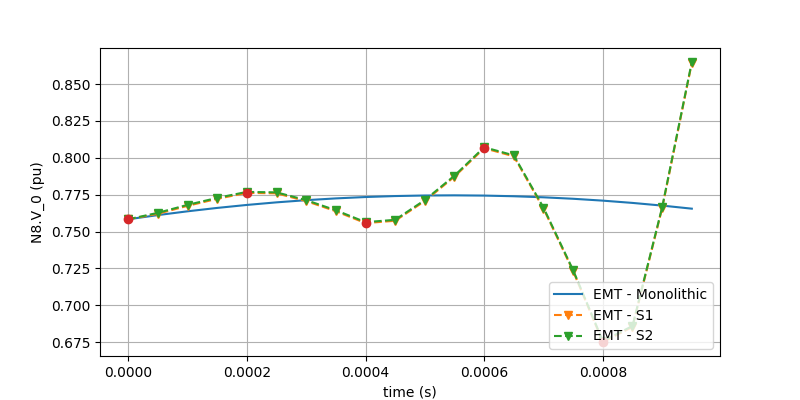

H=0.0002


In [15]:
varname_dpsim = 'N8.V'
nominal_voltage = 230000
plot_node_volt_abs(varname_dpsim, ts_dpsim_fault_emt, ts_dpsim_fault_s1_emt, ts_dpsim_fault_s2_emt, nominal_voltage, timestep_common)
print('H=' + str(H))

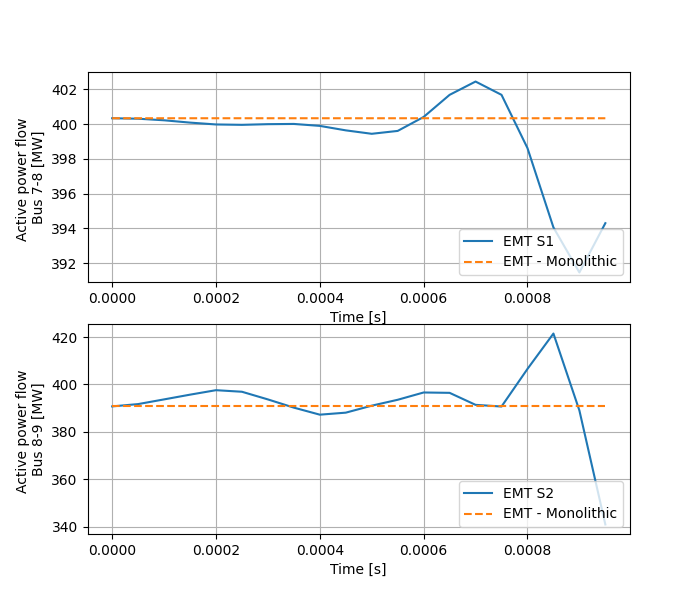

In [16]:
varname_dpsim = 'N8.V'
nominal_voltage = 230000
plot_power_area12(varname_dpsim, ts_dpsim_fault_emt, ts_dpsim_fault_s1_emt, ts_dpsim_fault_s2_emt, nominal_voltage, timestep_common)

Text(0, 0.5, 'Interface current')

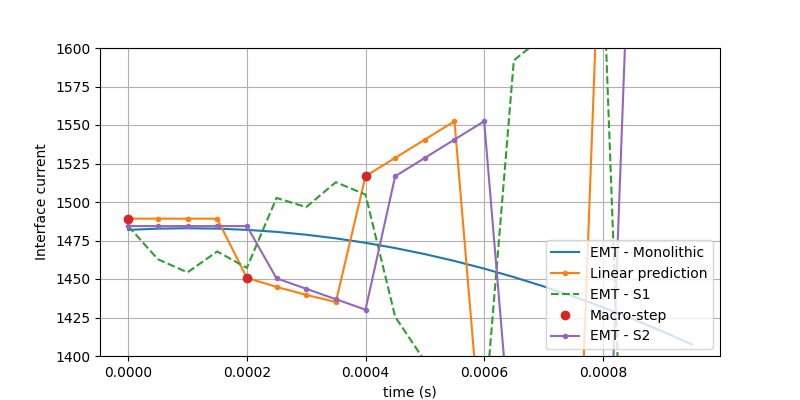

In [17]:
#plot parameters
width = 8
height = 4

#ts_mono = ts_dpsim_fault_emt["line3_7-8.I_0"].interpolate(timestep_common).time + ts_dpsim_fault_emt["line3_7-8.ParallelCurrentNode1_0"].interpolate(timestep_common).time 
ts_mono = ts_dpsim_fault_emt["line3_7-8.I_0"].interpolate(timestep_common).time
current_1_8_9 = ts_dpsim_fault_emt["line3_7-8.I_0"].interpolate(timestep_common).values
current_2_8_9 = ts_dpsim_fault_emt["line4_7-8.I_0"].interpolate(timestep_common).values
dpsim_emt_values = current_1_8_9 + current_2_8_9

ts_s1 = ts_dpsim_fault_s1_emt["VS_N8.I_0"].interpolate(timestep_common).time
# dpsim_emt_values_s1 = ts_dpsim_fault_s1_emt["line3_7-8.I_0"].interpolate(timestep_common).values + \
#     ts_dpsim_fault_s1_emt["line4_7-8.I_0"].interpolate(timestep_common).values
dpsim_emt_values_s1 = ts_dpsim_fault_s1_emt["VS_N8.I_0"].interpolate(timestep_common).values
# dpsim_emt_values_s1_H = ts_dpsim_fault_s1_emt["VS_N8.I_0"].interpolate(timestep_common_H).values[begin_idx_H:end_idx_H]

ts_s2 = ts_dpsim_fault_s2_emt["CS_N8.I_0"].interpolate(timestep_common).time
# dpsim_emt_values_s2 = ts_dpsim_fault_s2_emt["line5_8-9.I_0"].interpolate(timestep_common).values + \
#     ts_dpsim_fault_s2_emt["line6_8-9.I_0"].interpolate(timestep_common).values
dpsim_emt_values_s2 = ts_dpsim_fault_s2_emt["CS_N8.I_0"].interpolate(timestep_common).values
# dpsim_emt_values_s2_H = u_2_m_v[0,:]

u_2_m_v_H = u_2_m_v[0,range(begin_idx,end_idx,m)]

# ts_s2 = ts_dpsim_fault_s2_emt["CS_N8.I_0"].interpolate(timestep_common).time
# dpsim_emt_values_s2 = ts_dpsim_fault_s2_emt["CS_N8.I_0"].interpolate(timestep_common).values * dpsimpy.PEAK1PH_TO_RMS3PH
    
plt.figure(figsize=(width, height))
#plt.subplot(1, 2, 1)
plt.plot(ts_mono, dpsim_emt_values, label='EMT - Monolithic')
plt.plot(ts_mono, u_2_m_v[0,:], '.-', label='Linear prediction')
plt.plot(ts_s1, dpsim_emt_values_s1, '--', label='EMT - S1')
plt.plot(time_H, u_2_m_v_H, 'o', label='Macro-step')
plt.plot(ts_s2, dpsim_emt_values_s2, '.-', label='EMT - S2')
# plt.plot(time_H, dpsim_emt_values_s2_H, 'o', label='Macro-step')
plt.legend(loc='lower right')
plt.xlabel('time (s)')
plt.grid()
plt.ylim([1400, 1600])
# plt.ylim([-5000, 5000])
# plt.xlim([0, 0.6e-3])
plt.xlabel("time (s)")
plt.ylabel("Interface current")